# Train model

In [1]:
!nvidia-smi

Mon Apr  7 15:56:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 572.70         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   52C    P8              8W /   75W |     205MiB /   4096MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import gzip
import pickle
import numpy as np
from numpy import reshape
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-04-14 14:48:29.852226: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-14 14:48:29.915220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744616909.945488    3177 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744616909.955365    3177 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-14 14:48:30.022777: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    data = pickle._Unpickler(f)
    data.encoding = 'latin1'  # set encoding
    train_set, valid_test, test_set = data.load()

train_x, train_y = train_set
val_x, val_y = valid_test
test_x, test_y = test_set

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math

batch_size=256
n_batches = len(train_x) / batch_size
n_batches = math.ceil(n_batches)

train_x = train_x.reshape((-2, 28, 28, 1))
val_x = val_x.reshape((-2, 28, 28, 1))
test_x = test_x.reshape((-2, 28, 28, 1))

In [5]:
train_x.shape

(50000, 28, 28, 1)

In [6]:
def create_model():
    model = keras.Sequential(
        [
            keras.Input(shape=(28, 28, 1)),

            layers.Conv2D(filters = 4, kernel_size = (3, 3), strides = (1, 1), activation = 'relu'), 
            # layers.Conv2D(filters = 4, kernel_size = (3, 3), strides = (1, 1), activation = 'relu'), 
            layers.MaxPool2D(pool_size=(2, 2)),

            layers.Conv2D(filters = 8, kernel_size = (2, 2), strides = (1, 1), activation = 'relu'), 
            # layers.Conv2D(filters = 8, kernel_size = (3, 3), strides = (1, 1), activation = 'relu'), 
            layers.MaxPool2D(pool_size=(2, 2)),   

            layers.Conv2D(filters = 16, kernel_size = (3, 3), strides = (1, 1), activation = 'relu'), 
            layers.GlobalMaxPool2D(),                                                      
   
            layers.Dense(10)
        ]
    )

    
    return model

In [7]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

# Learning Rate Scheduling
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=600,  # Decay every 600 steps (≈2 epochs)
    decay_rate=0.9,
    staircase=True
)

model = create_model()
model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['accuracy']
    )
model.summary()
checkpoint_path = "training_1/cp2.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

W0000 00:00:1744016224.308283    6850 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 4)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 8)      │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 16)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,514 (5.91 KB)

 Trainable params: 1,514 (5.91 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_x, test_y, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

/home/nhat/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 - 1s - 4ms/step - accuracy: 0.9402 - loss: 0.2001
Restored model, accuracy: 94.02%


In [13]:
# Export weights example
for layer in model.layers:
    weights = layer.get_weights()
    if weights:
        print(f"// {layer.name} weights")
        print(f"static const float {layer.name}_weights[] = {{")
        print(", ".join(map(str, weights[0].flatten())))
        print("};\n")
        print(f"static const float {layer.name}_biases[] = {{")
        print(", ".join(map(str, weights[1].flatten())))
        print("};\n")

// conv2d weights
static const float conv2d_weights[] = {
-0.07325755, 1.1865675, -0.17460105, 0.40934697, 0.0067278566, 0.8636283, 0.45649847, 0.5782181, -0.2517621, 0.88706565, 0.5372558, 0.603698, -0.2393193, -0.22988063, -0.917086, 0.9243598, -0.1709271, 0.16026053, -1.2387735, 0.6723341, -0.2249587, 1.0668899, -0.9474671, 0.26665154, -0.3354636, -0.47381037, 0.75013095, 1.6653285, -0.1717411, -0.0008511407, 0.7554222, 1.1162299, -0.02599886, 0.9655173, 0.03283484, 0.3153005
};

static const float conv2d_biases[] = {
-0.0057602557, 0.009248344, 0.14225759, 0.0031061384
};

// conv2d_1 weights
static const float conv2d_1_weights[] = {
-0.01088712, -0.3036457, 0.24031475, -0.34698504, -0.26682404, -0.22727878, -0.18428035, 0.2874258, 0.28785935, 0.010403978, 0.5203401, 0.25949764, 0.5126956, -0.5555797, -0.055433907, 0.58513504, 0.6083265, 0.6415772, -0.6009929, -0.32115903, -0.4709797, 1.0332346, -0.055764534, 0.38916385, 0.018557593, 0.41868, 0.045105934, 0.23267984, 0.41250557, -0

In [10]:
# Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=False, verbose=1, save_freq=10*n_batches)
# ModelCheckpoint to save the best model
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    save_best_only=True,  # Save only the best model
    monitor='val_loss',    # Monitor validation loss
    mode='min',            # Minimization mode for val_loss
    verbose=1
)

# EarlyStopping callback
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=5,            # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore weights from the best epoch
)

model.fit(
    train_datagen.flow(train_x, train_y, batch_size=128),
    steps_per_epoch=len(train_x) // 128,
    epochs=30,             # Maximum number of epochs
    validation_data=(val_x, val_y),
    verbose=1,
    callbacks=[cp_callback, early_stop]  # Both callbacks added
)
# model.fit(
#     train_x,
#     train_y,
#     batch_size=64,
#     epochs=100,
#     validation_data=(val_x, val_y),
# )

loss, acc = model.evaluate(test_x, test_y, batch_size)
print("trained model, accuracy: {:5.2f}%".format(100 * acc))

Epoch 1/30
388/390 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9166 - loss: 0.2639
Epoch 1: val_loss improved from inf to 0.21154, saving model to training_1/cp2.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9166 - loss: 0.2639 - val_accuracy: 0.9376 - val_loss: 0.2115
Epoch 2/30
  1/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9297 - loss: 0.2305
Epoch 2: val_loss did not improve from 0.21154
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9297 - loss: 0.2305 - val_accuracy: 0.9376 - val_loss: 0.2117
Epoch 3/30
388/390 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9192 - loss: 0.2519
Epoch 3: val_loss did not improve from 0.21154
390/390 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9192 - loss: 0.2519 - val_accuracy: 0.9361 - val_loss: 0.2198
Epoch 4/30
  1/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9062 - loss: 0.2902
Epoch 4: val_loss did not improve from 0.21154
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9062 - loss: 0.2902 

In [15]:
# Save model
model.save_weights('weight/model.weights.h5')

In [16]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_x, test_y, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

313/313 - 1s - 3ms/step - accuracy: 0.9402 - loss: 0.2001
Restored model, accuracy: 94.02%


In [19]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpnjjvbd3e/assets


INFO:tensorflow:Assets written to: /tmp/tmpnjjvbd3e/assets


Saved artifact at '/tmp/tmpnjjvbd3e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_10')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140375175414000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140376804822352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140376804835024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140376804834496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140376804820944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140375175422624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140375175429664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140375174870672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140375174865040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140375174866624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140375174869

W0000 00:00:1743491437.321251     696 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1743491437.321288     696 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-01 14:10:37.321433: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpnjjvbd3e
2025-04-01 14:10:37.321959: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-01 14:10:37.321970: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpnjjvbd3e
2025-04-01 14:10:37.327961: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-01 14:10:37.357496: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpnjjvbd3e
2025-04-01 14:10:37.366176: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 44746 microseconds.


0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26171875, 0.90625, 0.15234375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2421875, 0.31640625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.46875, 0.703125, 0.15234375

TypeError: Invalid shape (784,) for image data

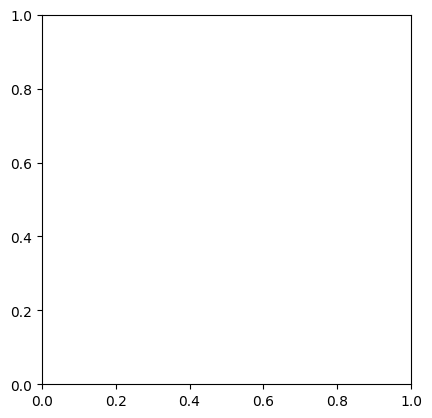

In [3]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
mnist_og = train_x[2]
for t in mnist_og.flatten():
    print(str(t) + ', ', end='')
plt.imshow(mnist_og, cmap=cm.Greys_r)
plt.show()

In [12]:
# mnist_og
mnist_og.shape
mnist_og = np.expand_dims(mnist_og, axis=0)
prediction = model.predict(mnist_og)
print(prediction[0])
print(np.argmax(prediction[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
[-1.3073918  -7.6151094  -0.39260054 -6.8166327   4.2385716  -4.772344
 -8.817055    1.9518112  -5.218283   -0.14352286]
4


In [19]:
weights11_np = np.round(model.layers[0].get_weights()[0][:, :, 0, 0], 3).flatten()
weights12_np = np.round(model.layers[0].get_weights()[0][:, :, 0, 1], 3).flatten()
bias11_np = np.round(model.layers[0].get_weights()[1][0], 3)
bias12_np = np.round(model.layers[0].get_weights()[1][1], 3)

In [22]:
print(weights11_np)
base_input = model.layers[0].input

[ 0.49   0.513  0.731  0.341  0.963  1.016  0.8    0.696  0.852  1.432
  0.658  0.839  0.425  1.338  1.584  0.922  1.109  0.637  0.302  0.984
  0.177 -0.128 -0.426 -0.158  0.238]


In [38]:
layer1_output1_np = np.round(tf.keras.Model(base_input, model.get_layer( model.layers[0].name ).output)(mnist_og)[0][:, :, 0].numpy().reshape(-1), 1)
layer1_output2_np = np.round(tf.keras.Model(base_input, model.get_layer( model.layers[0].name ).output)(mnist_og)[0][:, :, 1].numpy().reshape(-1), 1)

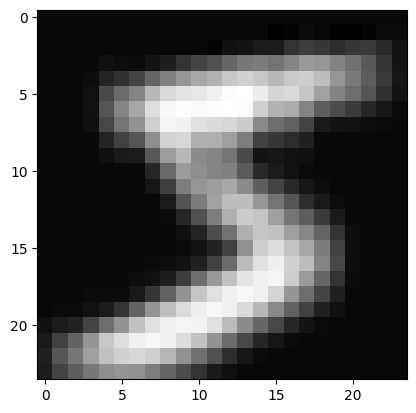

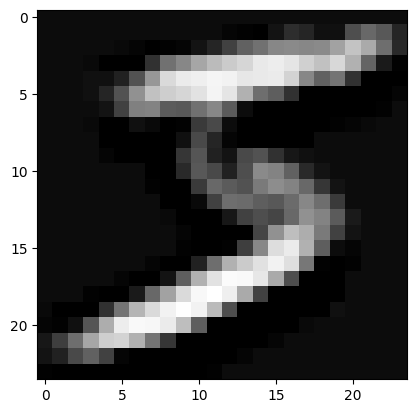

In [108]:
plt.imshow(layer1_output1_np.reshape((24,24)), cmap=cm.Greys_r)
plt.show()
plt.imshow(layer1_output2_np.reshape((24,24)), cmap=cm.Greys_r)
plt.show()

In [40]:
maxpool1_output1_np = np.round(tf.keras.Model(base_input, model.get_layer( model.layers[1].name ).output)(mnist_og)[0][:, :, 0].numpy(), 1).flatten()
maxpool1_output2_np = np.round(tf.keras.Model(base_input, model.get_layer( model.layers[1].name ).output)(mnist_og)[0][:, :, 1].numpy(), 1).flatten()

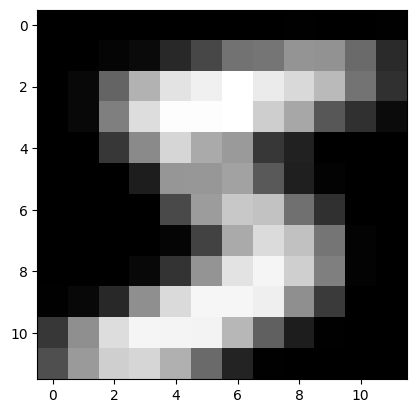

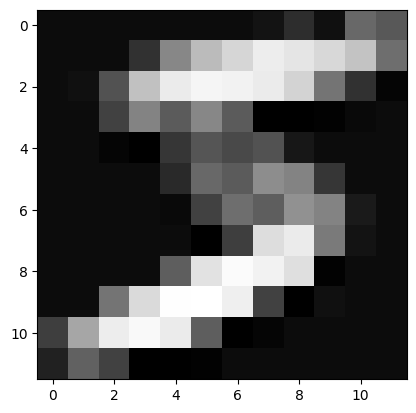

In [116]:
plt.imshow(maxpool1_output1_np.reshape((12,12)), cmap=cm.Greys_r)
plt.show()
plt.imshow(maxpool1_output2_np.reshape((12,12)), cmap=cm.Greys_r)
plt.show()

In [36]:
weights21_1_np = np.round(model.layers[2].get_weights()[0][:, :, 0, 0], 3)
weights21_2_np = np.round(model.layers[2].get_weights()[0][:, :, 1, 0], 3)

weights22_1_np = np.round(model.layers[2].get_weights()[0][:, :, 0, 1], 3)
weights22_2_np = np.round(model.layers[2].get_weights()[0][:, :, 1, 1], 3)

weights23_1_np = np.round(model.layers[2].get_weights()[0][:, :, 0, 2], 3)
weights23_2_np = np.round(model.layers[2].get_weights()[0][:, :, 1, 2], 3)

weights24_1_np = np.round(model.layers[2].get_weights()[0][:, :, 0, 3], 3)
weights24_2_np = np.round(model.layers[2].get_weights()[0][:, :, 1, 3], 3)

In [37]:
bias21_np = np.round(model.layers[2].get_weights()[1][0], 3)
bias22_np = np.round(model.layers[2].get_weights()[1][1], 3)
bias23_np = np.round(model.layers[2].get_weights()[1][2], 3)
bias24_np = np.round(model.layers[2].get_weights()[1][3], 3)

In [43]:
layer2_output1_np = tf.keras.Model(base_input, model.get_layer( model.layers[2].name ).output)(mnist_og)[0][:, :, 0].numpy().reshape(-1)
layer2_output2_np = tf.keras.Model(base_input, model.get_layer( model.layers[2].name ).output)(mnist_og)[0][:, :, 1].numpy().reshape(-1)
layer2_output3_np = tf.keras.Model(base_input, model.get_layer( model.layers[2].name ).output)(mnist_og)[0][:, :, 2].numpy().reshape(-1)
layer2_output4_np = tf.keras.Model(base_input, model.get_layer( model.layers[2].name ).output)(mnist_og)[0][:, :, 3].numpy().reshape(-1)

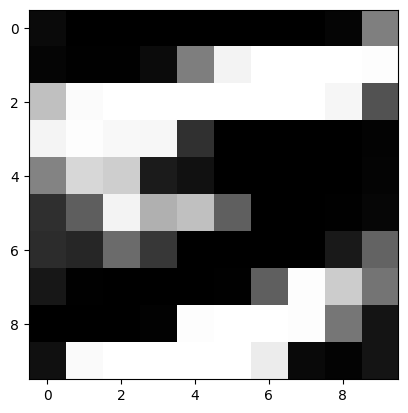

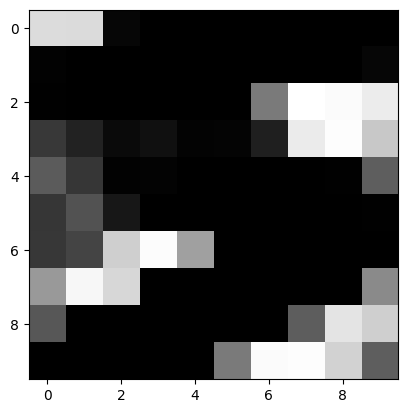

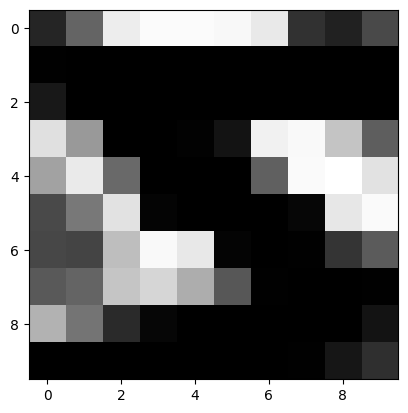

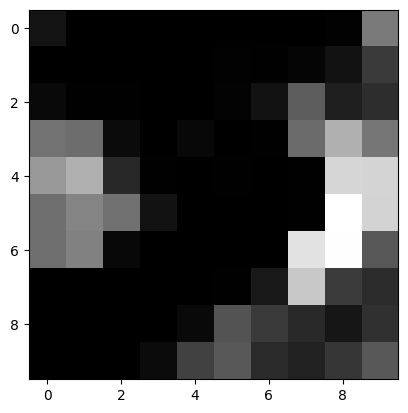

In [117]:
plt.imshow(layer2_output1_np.reshape((10,10)), cmap=cm.Greys_r)
plt.show()
plt.imshow(layer2_output2_np.reshape((10,10)), cmap=cm.Greys_r)
plt.show()
plt.imshow(layer2_output3_np.reshape((10,10)), cmap=cm.Greys_r)
plt.show()
plt.imshow(layer2_output4_np.reshape((10,10)), cmap=cm.Greys_r)
plt.show()

In [44]:
maxpool2_output1_np = tf.keras.Model(base_input, model.get_layer( model.layers[3].name ).output)(mnist_og)[0][:, :, 0].numpy().reshape(-1)
maxpool2_output2_np = tf.keras.Model(base_input, model.get_layer( model.layers[3].name ).output)(mnist_og)[0][:, :, 1].numpy().reshape(-1)
maxpool2_output3_np = tf.keras.Model(base_input, model.get_layer( model.layers[3].name ).output)(mnist_og)[0][:, :, 2].numpy().reshape(-1)
maxpool2_output4_np = tf.keras.Model(base_input, model.get_layer( model.layers[3].name ).output)(mnist_og)[0][:, :, 3].numpy().reshape(-1)

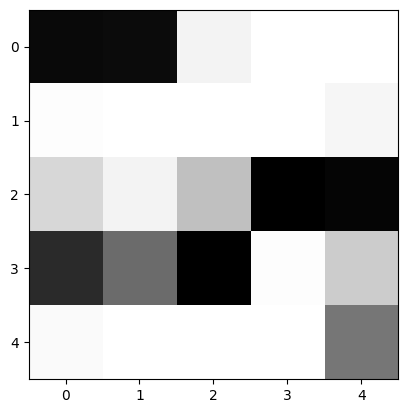

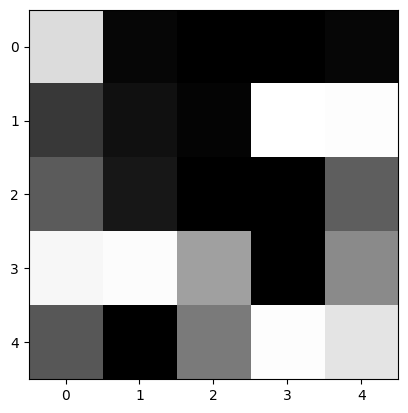

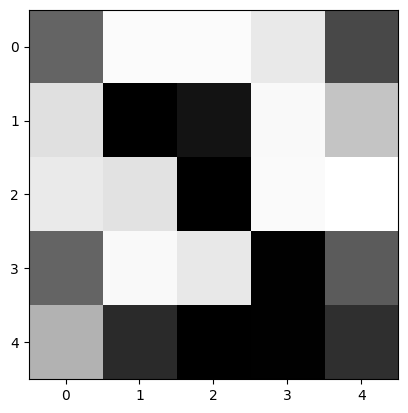

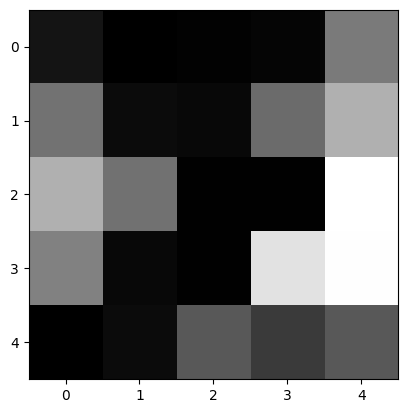

In [118]:
plt.imshow(maxpool2_output1_np.reshape((5,5)), cmap=cm.Greys_r)
plt.show()
plt.imshow(maxpool2_output2_np.reshape((5,5)), cmap=cm.Greys_r)
plt.show()
plt.imshow(maxpool2_output3_np.reshape((5,5)), cmap=cm.Greys_r)
plt.show()
plt.imshow(maxpool2_output4_np.reshape((5,5)), cmap=cm.Greys_r)
plt.show()

In [46]:
flatten_output_np = tf.keras.Model(base_input, model.get_layer( model.layers[4].name ).output)(mnist_og)[0].numpy().reshape(-1)   ## FULL FLATTEN LAYER

In [50]:
print(flatten_output_np)
print(flatten_output_np.shape)

[3.5534725e-02 7.6211095e-01 3.1377038e-01 6.8130493e-02 4.2812757e-02
 2.5527379e-02 9.5099843e-01 4.2409116e-05 9.0326017e-01 1.6839130e-07
 9.5097083e-01 9.6737379e-03 9.9987817e-01 3.6945991e-10 8.1971884e-01
 2.1339051e-02 9.9915123e-01 2.6033159e-02 2.2162145e-01 3.8476381e-01
 9.8651505e-01 1.7987257e-01 7.7429777e-01 3.5625178e-01 9.9866295e-01
 5.5076201e-02 5.3569960e-04 4.0282197e-02 9.9982214e-01 1.8053068e-02
 6.6551208e-02 2.7646579e-02 9.9886310e-01 9.9073952e-01 9.3509883e-01
 3.2980049e-01 9.2775595e-01 9.7720462e-01 6.4399844e-01 5.5819488e-01
 7.4493283e-01 2.8406477e-01 8.2897878e-01 5.5982262e-01 8.9915740e-01
 7.8258619e-02 7.8424168e-01 3.5470492e-01 6.3919866e-01 1.0553700e-03
 3.2302297e-03 5.3098826e-03 2.7142623e-03 1.7190068e-04 9.4260991e-01
 7.1652774e-03 2.5177894e-02 2.9734355e-01 9.7817069e-01 9.5744318e-01
 1.4664166e-01 9.2900491e-01 3.1439790e-01 4.0790361e-01 3.4687161e-01
 9.6506083e-01 9.3125838e-01 2.9891623e-02 4.5174202e-03 5.2727073e-01
 8.173

In [102]:
weights31_np = np.round(model.layers[5].get_weights()[0][:, 0], 3)
bias31_np = np.round(model.layers[5].get_weights()[1][0], 3)

[-0.969  0.544  0.069  0.951 -0.751 -0.18  -0.601 -0.306 -0.401  0.362
  0.265 -0.819 -0.408 -0.478 -0.102 -1.009  0.212 -0.832  0.883 -0.644
  0.627  0.605 -0.768 -0.269 -0.381  0.111 -0.62   0.642  1.353 -0.954
 -0.132  1.37   0.482 -0.702 -0.501 -0.024 -1.356 -3.429 -0.144 -1.139
  0.084 -0.916 -3.651  0.34  -0.371 -0.796 -1.202  0.116  0.565  0.593
 -0.05   2.044 -1.175  0.392 -0.187  0.813 -0.09  -2.912 -0.976  0.298
 -0.415 -3.7   -2.835 -0.163 -1.25  -0.735 -0.911 -1.333 -1.803 -1.043
  0.079  0.616 -0.81   0.022  0.394  0.422  0.672  1.536 -0.85   0.146
  1.302 -1.48  -0.403 -0.544  0.741 -1.074  0.318 -0.387  0.871  0.236
  1.894 -1.864  1.235  1.19   1.285 -0.091  0.631  1.207 -0.532  0.396]
(100,)


0.578

In [47]:
output_np = tf.keras.Model(base_input, model.get_layer( model.layers[5].name ).output)(mnist_og)[0].numpy().reshape(-1)
output_np

array([-11.59459  , -10.063299 ,  -7.3010254,   1.6951506, -10.857957 ,
         6.25559  , -11.002987 ,  -7.47182  ,  -2.5830317,  -5.1626534],
      dtype=float32)

# Caculate network

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

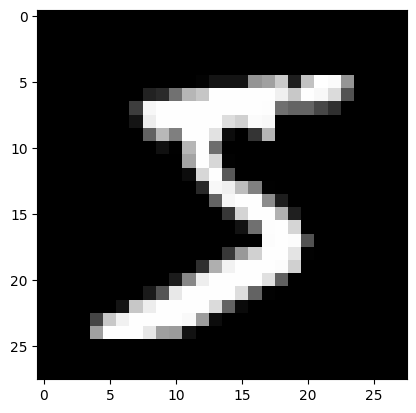

In [63]:
test = train_x[0]
plt.imshow(test, cmap=cm.Greys_r)
plt.show()

In [67]:
test = test.flatten()

In [68]:
weights11_np = np.round(model.layers[0].get_weights()[0][:, :, 0, 0], 3).flatten()
weights12_np = np.round(model.layers[0].get_weights()[0][:, :, 0, 1], 3).flatten()
bias11_np = np.round(model.layers[0].get_weights()[1][0], 3)
bias12_np = np.round(model.layers[0].get_weights()[1][1], 3)

In [70]:
np.sum(test.reshape((28,28))[0:5,0:5]*weights11_np.reshape((5,5)))+bias11_np

1.079

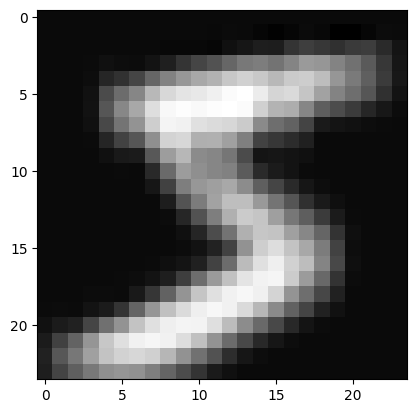

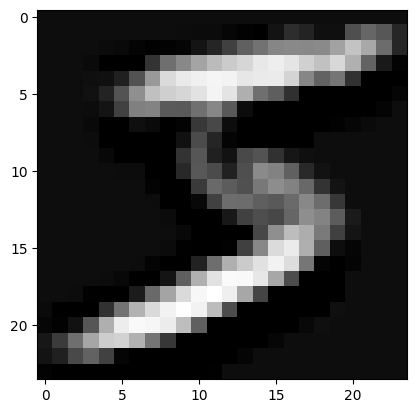

In [110]:
test.reshape((28,28))
a1 = np.zeros((24,24), dtype=float)
a2 = np.zeros((24,24), dtype=float)
for i in range(24):
    for j in range(24):
        a1[i][j]= np.sum(test.reshape((28,28))[i:i+5,j:j+5]*np.round(model.layers[0].get_weights()[0][:, :, 0, 0], 3))+np.round(model.layers[0].get_weights()[1][0], 3)
        if a1[i][j] <0: a1[i][j]=0
        a2[i][j]= np.sum(test.reshape((28,28))[i:i+5,j:j+5]*np.round(model.layers[0].get_weights()[0][:, :, 0, 1], 3))+np.round(model.layers[0].get_weights()[1][1], 3)
        if a2[i][j] <0: a2[i][j]=0
plt.imshow(a1, cmap=cm.Greys_r)
plt.show()
plt.imshow(a2, cmap=cm.Greys_r)
plt.show()

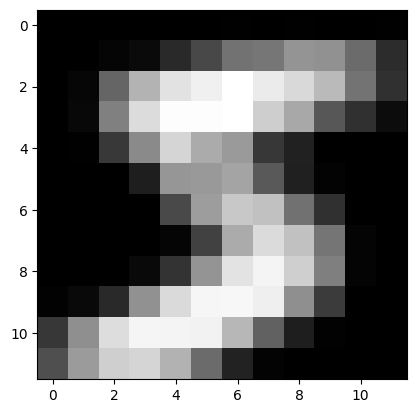

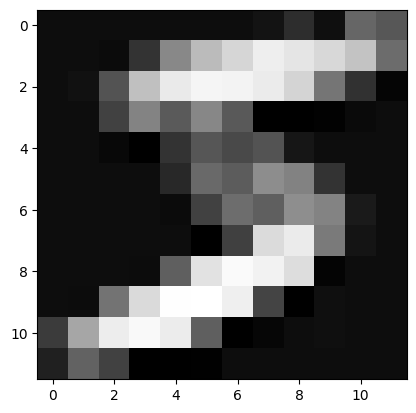

In [111]:
b1 = np.zeros((12,12), dtype=float)
b2 = np.zeros((12,12), dtype=float)
for i in range(12):
    for j in range(12):
        b1[i][j]= np.max(a1[2*i:2*i+2,2*j:2*j+2])
        b2[i][j]= np.max(a2[2*i:2*i+2,2*j:2*j+2])
plt.imshow(b1, cmap=cm.Greys_r)
plt.show()
plt.imshow(b2, cmap=cm.Greys_r)
plt.show()

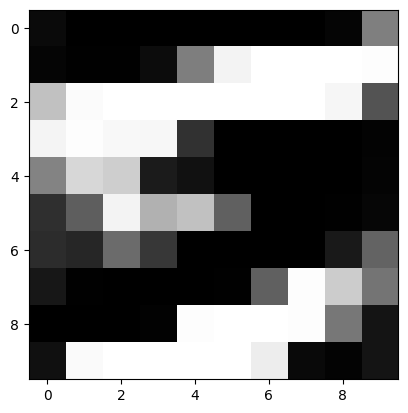

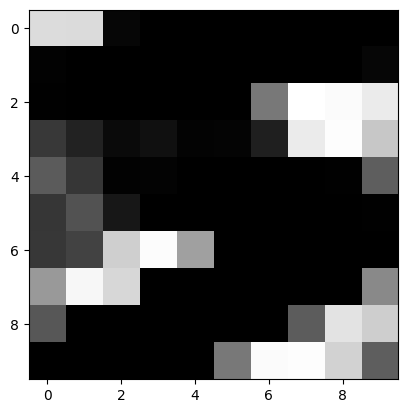

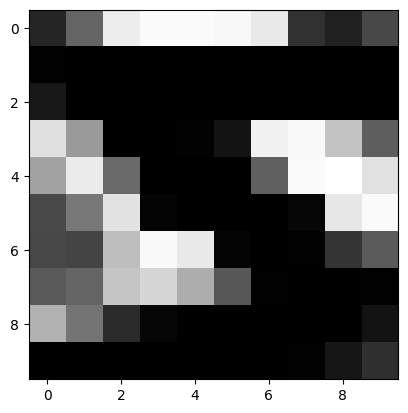

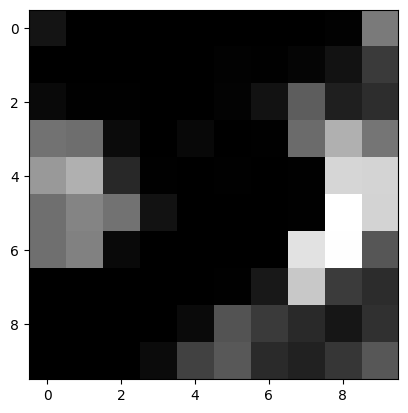

In [112]:
import math
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
    
c1 = np.zeros((10,10), dtype=float)
c2 = np.zeros((10,10), dtype=float)
c3 = np.zeros((10,10), dtype=float)
c4 = np.zeros((10,10), dtype=float)
for i in range(10):
    for j in range(10):
        c1[i][j]= sigmoid(np.sum(b1[i:i+3,j:j+3]*weights21_1_np.reshape((3,3)))+np.sum(b2[i:i+3,j:j+3]*weights21_2_np.reshape((3,3)))+bias21_np)
        c2[i][j]= sigmoid(np.sum(b1[i:i+3,j:j+3]*weights22_1_np.reshape((3,3)))+np.sum(b2[i:i+3,j:j+3]*weights22_2_np.reshape((3,3)))+bias22_np)
        c3[i][j]= sigmoid(np.sum(b1[i:i+3,j:j+3]*weights23_1_np.reshape((3,3)))+np.sum(b2[i:i+3,j:j+3]*weights23_2_np.reshape((3,3)))+bias23_np)
        c4[i][j]= sigmoid(np.sum(b1[i:i+3,j:j+3]*weights24_1_np.reshape((3,3)))+np.sum(b2[i:i+3,j:j+3]*weights24_2_np.reshape((3,3)))+bias24_np)
plt.imshow(c1, cmap=cm.Greys_r)
plt.show()
plt.imshow(c2, cmap=cm.Greys_r)
plt.show()
plt.imshow(c3, cmap=cm.Greys_r)
plt.show()
plt.imshow(c4, cmap=cm.Greys_r)
plt.show()

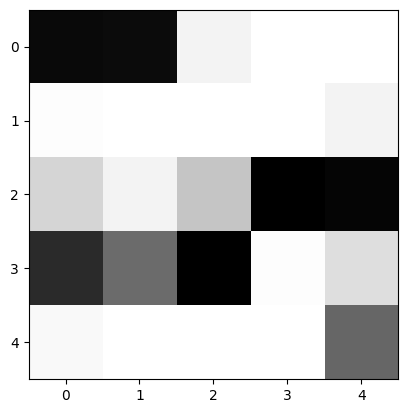

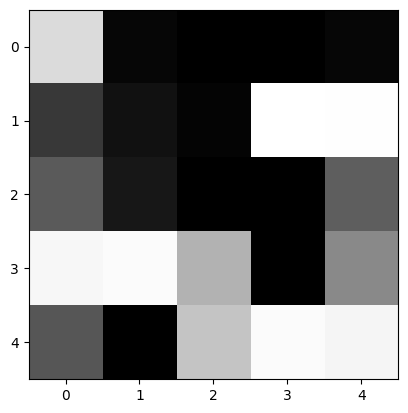

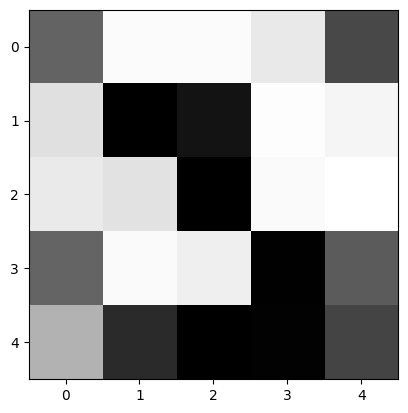

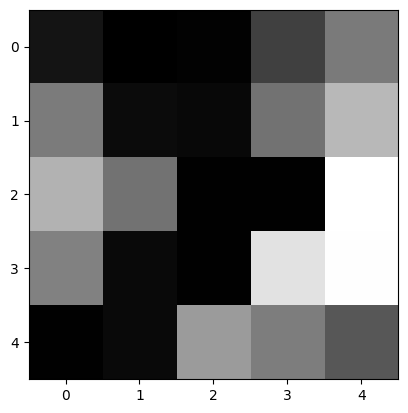

In [95]:
d1 = np.zeros((5,5), dtype=float)
d2 = np.zeros((5,5), dtype=float)
d3 = np.zeros((5,5), dtype=float)
d4 = np.zeros((5,5), dtype=float)
for i in range(5):
    for j in range(5):
        d1[i][j]= np.max(c1[2*i:2*i+2,2*j:2*j+2])
        d2[i][j]= np.max(c2[2*i:2*i+2,2*j:2*j+2])
        d3[i][j]= np.max(c3[2*i:2*i+2,2*j:2*j+2])
        d4[i][j]= np.max(c4[2*i:2*i+2,2*j:2*j+2])
plt.imshow(d1, cmap=cm.Greys_r)
plt.show()
plt.imshow(d2, cmap=cm.Greys_r)
plt.show()
plt.imshow(d3, cmap=cm.Greys_r)
plt.show()
plt.imshow(d4, cmap=cm.Greys_r)
plt.show()

In [127]:
e = np.array([])
for t in [d1, d2, d3, d4]:
    e = np.append(e, t.flatten()) 
e = e.reshape((4,25))
e = e.flatten('F')
e

array([3.56161002e-02, 7.61920650e-01, 3.13549541e-01, 6.82430172e-02,
       4.31499461e-02, 2.55778467e-02, 9.50939719e-01, 4.27297886e-05,
       9.03616484e-01, 1.68897143e-07, 9.50834132e-01, 1.06989855e-02,
       9.99924253e-01, 2.78263995e-10, 8.19175231e-01, 1.91145863e-01,
       9.99518809e-01, 2.58129964e-02, 2.20805855e-01, 3.84087004e-01,
       9.86993798e-01, 1.79840812e-01, 7.74658919e-01, 3.87262855e-01,
       9.98738688e-01, 6.09719049e-02, 5.93699391e-04, 4.03419919e-02,
       9.99825934e-01, 1.69933508e-02, 6.61820951e-02, 2.77898222e-02,
       9.99118613e-01, 9.97229494e-01, 9.66475781e-01, 3.56664584e-01,
       9.02727787e-01, 9.88084666e-01, 8.94509558e-01, 5.84763846e-01,
       7.34461576e-01, 2.84075747e-01, 8.24444097e-01, 5.68131535e-01,
       8.99674526e-01, 7.82908087e-02, 7.84793328e-01, 3.55573882e-01,
       6.63405824e-01, 1.00016121e-03, 3.23081483e-03, 5.32204260e-03,
       2.72593965e-03, 1.71196963e-04, 9.42516610e-01, 7.15148664e-03,
      

In [131]:
f = np.array([])
for i in range(10):
    f = np.append(f,np.sum(np.round(model.layers[5].get_weights()[0][:, i], 3)*e) + np.round(model.layers[5].get_weights()[1][i], 3))
f

array([-12.18892483,  -9.80781183,  -7.70715677,   1.66110292,
       -10.65804145,   6.07372628, -11.16655421,  -7.79224972,
        -3.5183737 ,  -5.07452491])

In [129]:
np.argmax(f)

5